In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy

from sklearn.cluster import SpectralClustering, KMeans
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import PowerIterationClustering

import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

In [3]:
def get_sorted_eigendecomposition(G, k):
  laplacian_matrix = nx.normalized_laplacian_matrix(G).toarray()

  eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian_matrix, k)

  if np.iscomplexobj(eigenvalues) or np.iscomplexobj(eigenvectors):
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    
  sorted_indices = np.argsort(eigenvalues)
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]

  return eigenvalues, eigenvectors


def ideal_clusters_n(eigenvalues):
  eigengap = np.diff(eigenvalues)

  eigengap_peaks = np.where(np.diff(eigengap) < 0)[0]
  return eigengap_peaks[0] + 1


def preview_clustering(G, pos, cluster_labels):
  # Draw the nodes with different colors based on their cluster labels
  next_color = [.6, .4, .3]
  for cluster_label in range(20):
      next_color[(cluster_label*5)%3] = (next_color[(cluster_label)%3] + .28*cluster_label) % 1
      nodes_in_cluster = [node for node, label in zip(G.nodes(), cluster_labels) if label == cluster_label]
      nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, node_color=pltcolors.to_hex(next_color), node_size=10)

  plt.title('Spectral Clustering')
  plt.show()

In [4]:
def kmeans_cluster_partitioning(eigenvectors, n_clusters):
  cluster_vectors = eigenvectors[:, :n_clusters]

  kmeans = KMeans(n_clusters=n_clusters)
  return kmeans.fit_predict(cluster_vectors)

In [5]:
def scikit_cluster_partitioning(G, n_clusters):
  spectral_clustering = SpectralClustering(n_clusters, eigen_solver='amg', affinity='precomputed', n_jobs=4)
  return spectral_clustering.fit_predict(nx.adjacency_matrix(G, weight=None).toarray())

In [6]:
def spark_cluster_partitioning(G, n_clusters):
  # Spark Constants
  APP_NAME = 'assignment1'
  MASTER = 'local[*]'

  spark = SparkSession.builder.appName("SpectralClustering").getOrCreate()
  
  conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER)
  sc = SparkContext.getOrCreate(conf=conf)
  
  edges = [(int(edge[0]), int(edge[1]), 1.0) for edge in G.edges()]
  rdd = sc.parallelize(edges)
  
  model = PowerIterationClustering.train(rdd, n_clusters, 10, 'degree')
  cluster_labels = model.assignments().map(lambda x: x.cluster).collect()

  spark.stop()

  return cluster_labels


## High Energy Physics - Phenomenology collaboration network

In [19]:
G = nx.read_edgelist("ca-HepPh.txt.gz")

pos = nx.random_layout(G)

optimal_num_clusters = 20
eigenvalues, eigenvectors = get_sorted_eigendecomposition(G, optimal_num_clusters)

optimal_num_clusters

20

/home/pedro-duarte/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


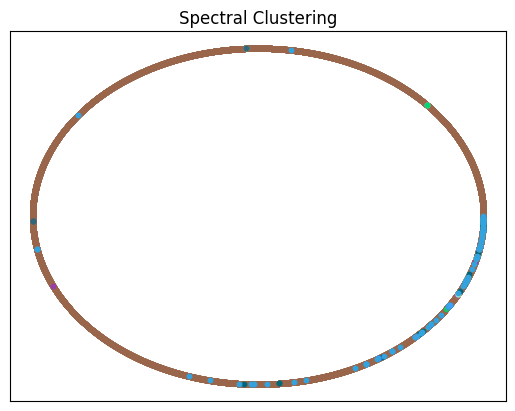

In [20]:
cluster_labels = kmeans_cluster_partitioning(eigenvectors, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

/home/pedro-duarte/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


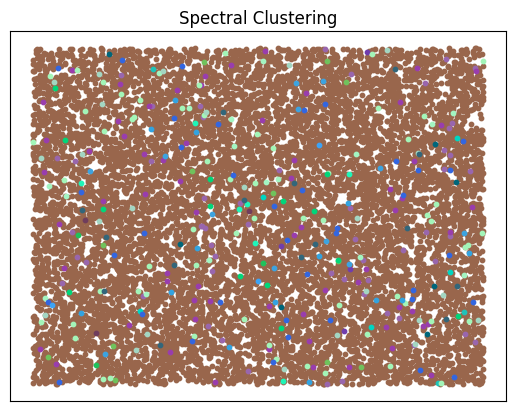

In [9]:
cluster_labels = scikit_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

23/06/08 17:20:33 WARN Utils: Your hostname, pedro-duarte resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp2s0)
23/06/08 17:20:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/08 17:20:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


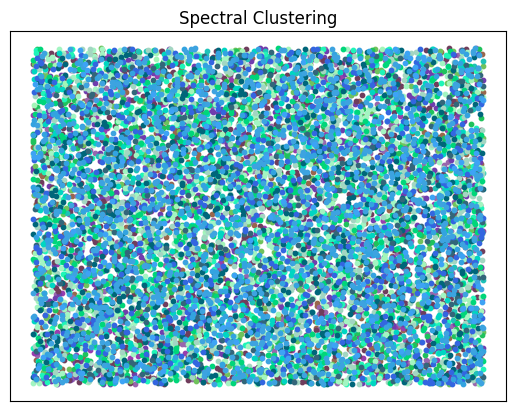

In [10]:
cluster_labels = spark_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

## Social circles: Facebook

In [11]:
G = nx.read_edgelist("facebook_combined.txt.gz")

pos = nx.random_layout(G)

optimal_num_clusters = 20
eigenvalues, eigenvectors = get_sorted_eigendecomposition(G, optimal_num_clusters)

optimal_num_clusters

20

/home/pedro-duarte/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


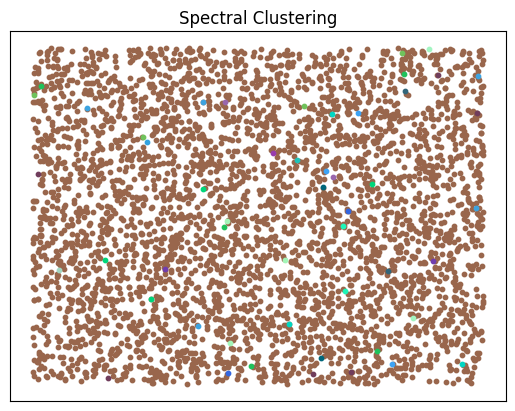

In [12]:
cluster_labels = kmeans_cluster_partitioning(eigenvectors, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

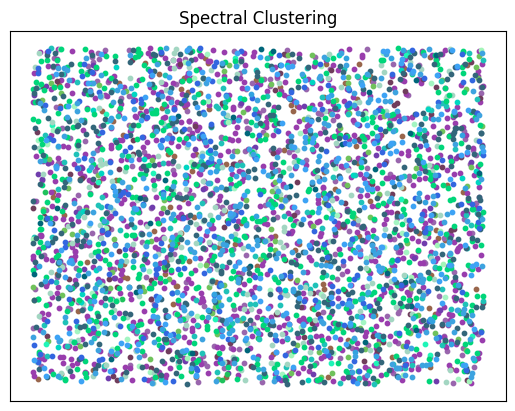

In [13]:
cluster_labels = scikit_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

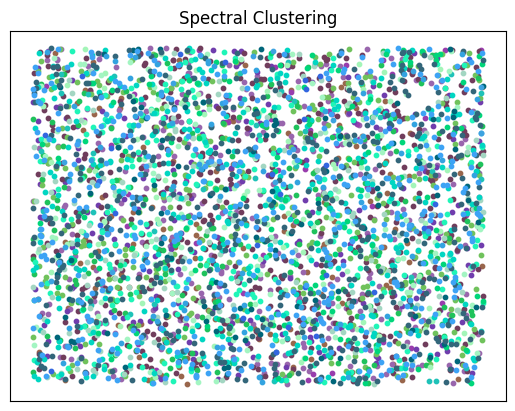

In [14]:
cluster_labels = spark_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

## Human protein-protein interaction network

In [15]:
data = pd.read_csv("PP-Pathways_ppi.csv.gz", header=None)

G = nx.from_pandas_edgelist(data, source=0, target=1)

pos = nx.random_layout(G)

optimal_num_clusters = 20
eigenvalues, eigenvectors = get_sorted_eigendecomposition(G, optimal_num_clusters)

optimal_num_clusters

20

/home/pedro-duarte/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


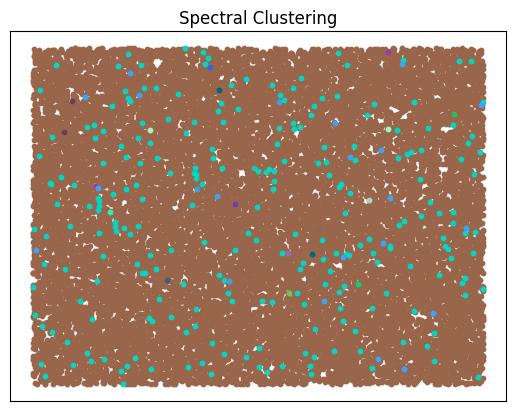

In [16]:
cluster_labels = kmeans_cluster_partitioning(eigenvectors, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

/home/pedro-duarte/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


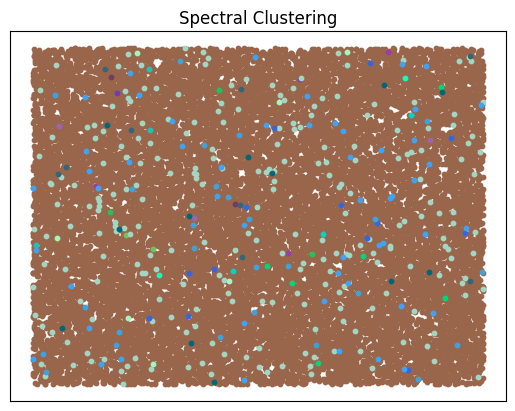

In [17]:
cluster_labels = scikit_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)

23/06/08 17:27:45 WARN TaskSetManager: Stage 0 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.


23/06/08 17:27:50 WARN TaskSetManager: Stage 1 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:50 WARN TaskSetManager: Stage 2 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.


23/06/08 17:27:51 WARN TaskSetManager: Stage 4 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.


23/06/08 17:27:51 WARN TaskSetManager: Stage 13 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:51 WARN TaskSetManager: Stage 18 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:52 WARN TaskSetManager: Stage 26 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:52 WARN TaskSetManager: Stage 40 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:52 WARN TaskSetManager: Stage 47 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.


23/06/08 17:27:53 WARN TaskSetManager: Stage 50 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:53 WARN TaskSetManager: Stage 67 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.


23/06/08 17:27:54 WARN TaskSetManager: Stage 72 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:54 WARN TaskSetManager: Stage 80 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:55 WARN TaskSetManager: Stage 100 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:55 WARN TaskSetManager: Stage 114 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:55 WARN TaskSetManager: Stage 116 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:56 WARN TaskSetManager: Stage 139 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
23/06/08 17:27:56 WARN TaskSetManager: Stage 156 contains a task of very large size (1456 KiB). The maximum recommended task size is 1000 KiB.
2

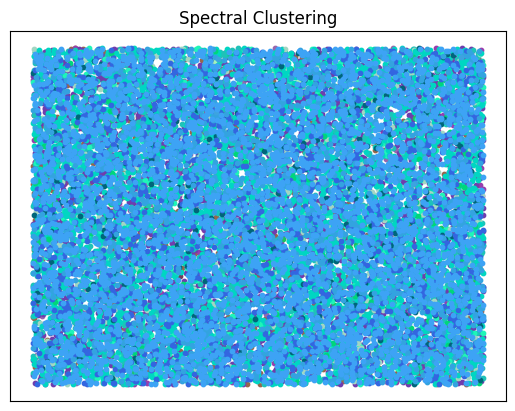

In [18]:
cluster_labels = spark_cluster_partitioning(G, optimal_num_clusters)
preview_clustering(G, pos, cluster_labels)